# Predicting stock price of JSW Holding for the year 2019 from 2018 data

In [1]:
import numpy as np
import math
import matplotlib
import pandas as pd
import seaborn as sns
import time
from datetime import date, datetime,timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from tqdm import tqdm_notebook
from pylab import rcParams
import talib

In [2]:
import os
os.getcwd()
os.chdir("D:\\NagarajLearning\\DataScience\\DataSets")
os.getcwd()

'D:\\NagarajLearning\\DataScience\\DataSets'

In [3]:
#Time series imports
import joblib
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 

In [4]:
df_s= pd.read_excel("NSE 2018 data.xlsx")
df_s.head()

,SYMBOL,sector,OPEN,HIGH,LOW,CLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES
0,20MICRONS,Mining,58.95,60.70,57.90,58.75,156506,9316661.05,2018-01-01,1527
1,20MICRONS,Mining,58.75,60.55,57.65,58.05,173946,10190754.15,2018-01-02,994
2,20MICRONS,Mining,58.70,60.50,58.50,59.20,191320,11345473.80,2018-01-03,1004
3,20MICRONS,Mining,59.45,63.20,58.60,62.60,812025,50057113.35,2018-01-04,5189
4,20MICRONS,Mining,64.80,67.00,63.00,63.60,1129498,73646779.85,2018-01-05,7645


In [5]:
# Stocks clustered.
df_clustered_stocks= pd.read_csv("df_stocks_cluster_sector.csv")
df_clustered_stocks.rename(columns={"Unnamed: 0":"stocks","predicted_cluster":"cluster"},inplace=True)
df_clustered_stocks.head()

,stocks,stdev,mean,coef_variance,cluster
0,ALANKIT,0.445145,0.895359,0.013327,0
1,BAJAJFINSV,0.105723,0.994396,0.000018,3
2,BAJAJHLDNG,0.059611,0.998222,0.000021,3
3,BAJFINANCE,0.160914,0.986968,0.000072,1
4,BFINVEST,0.162691,0.986677,0.000572,1


In [6]:
#Segreated the cluster
cluster_1=df_clustered_stocks.query("cluster==0")['stocks']
cluster_2=df_clustered_stocks.query("cluster==1")['stocks']
cluster_3=df_clustered_stocks.query("cluster==2")['stocks']
cluster_4=df_clustered_stocks.query("cluster==3")['stocks']
df_C1 = pd.DataFrame(pd.Series(cluster_1).reset_index())
df_C2 = pd.DataFrame(pd.Series(cluster_2).reset_index())
df_C3 = pd.DataFrame(pd.Series(cluster_3).reset_index())
df_C4 = pd.DataFrame(pd.Series(cluster_4).reset_index())

df_c = pd.concat([df_C1,df_C2,df_C3,df_C4],ignore_index=True,axis=1)

df_c.drop([0,2,4,6],axis=1,inplace=True)
df_c.rename(columns={1:"cluster_1",3:"cluster_2",5:"cluster_3",7:"cluster_4"},inplace=True)
df_c.head()

,cluster_1,cluster_2,cluster_3,cluster_4
0,ALANKIT,BAJFINANCE,CANFINHOME,BAJAJFINSV
1,DHFL,BFINVEST,DHUNINV,BAJAJHLDNG
2,GRUH,CGCL,EDELWEISS,CHOLAFIN
3,IVC,IBULHSGFIN,EMKAY,HDFC
4,NAGREEKCAP,IDFC,GICHSGFIN,JSWHL


In [7]:
# We took randomly 1 stock for each cluster
# Now Cluster 1,2,3 stocks are predicted 
# I will take a stock from cluster 4 JSW Holdings

In [8]:
df_jsw_comp = df_s.query('SYMBOL == "JSWHL"').copy()


In [9]:
df_jsw_comp.shape

(215, 10)

In [10]:
df_jsw_comp.head()

,SYMBOL,sector,OPEN,HIGH,LOW,CLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES
147020,JSWHL,Finance,1830.0,1830.0,1760.0,1779.20,3803,6789442.10,2018-01-01,480
147021,JSWHL,Finance,1767.0,1805.0,1767.0,1797.35,7243,12932038.45,2018-01-02,261
147022,JSWHL,Finance,1808.8,1812.0,1778.1,1781.65,6025,10862772.90,2018-01-03,269
147023,JSWHL,Finance,1810.0,1829.0,1771.0,1778.70,26153,47052442.70,2018-01-04,961
147024,JSWHL,Finance,1796.8,1805.0,1770.0,1784.35,10834,19466163.25,2018-01-05,627


In [11]:
#Helper method for cleaning the data
def Clean_Data(df):
    df['date'] = pd.to_datetime(df_s.TIMESTAMP)
    df.drop(['TIMESTAMP','sector'],axis=1,inplace=True)
    df.rename(columns={'TOTTRDQTY':'volume', \
                               "OPEN":"open", "HIGH":"high", \
                               "LOW":"low","CLOSE":"close", \
                               "TOTTRDVAL":"total_tv", \
                               "TOTALTRADES":"totaltrades", \
                               "SYMBOL":"symbol","Date":"date"},inplace=True)
    df.sort_values(by=['symbol','date'],ascending=True,inplace=True)
    df.index = pd.DatetimeIndex(df['date'])
    df= df.asfreq('b')
    df=df.fillna(method='ffill')
    df=df[['date','close']]
   # df.set_index('date',inplace=True )
    return df

In [12]:
#Helper method for plotting the graph easily
def plotGraph(df,dfName):
    rcParams['figure.figsize']=10,8
    ax = df.plot(x='date',y='close',style='b',grid=True)
    ax.set_xlabel("Date")
    ax.set_ylabel("Close price")
    plt.title(dfName)
    #ax.title=dfName

In [13]:
#Helper method for creating the test and train split
def getTrainTestSplit(input_df,split_size):
    size = int(len(input_df)*split_size)
    df= pd.DataFrame()
    df=input_df.copy()
    train = df[:size].copy()
    test =df[size:].copy()
    return train,test

In [14]:
#Cleaning the data
df_jsw_comp=Clean_Data(df_jsw_comp)

In [15]:
df_jsw_comp.head()
#We can see that the data is clean and we only have the columns that we 
# are interested in 
# Also the data is sorted based on dates ascending

,date,close
date,,
2018-01-01,2018-01-01,1779.20
2018-01-02,2018-01-02,1797.35
2018-01-03,2018-01-03,1781.65
2018-01-04,2018-01-04,1778.70
2018-01-05,2018-01-05,1784.35


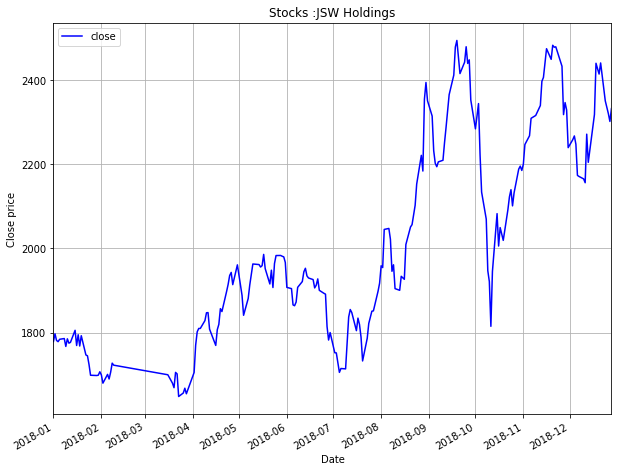

In [16]:
#Lets plot and see how the stocks perform overtime
plotGraph(df_jsw_comp,'Stocks :JSW Holdings')

In [17]:
#Careffully observing the stocks we can see that the stock has the following 
# Trend
#Somtimes seasonal
# Sudden following by bullish stauing there for a while followed by sudden down trend
#The period of time where the stock in bearish is comparitively low as compared to it bullish period



In [18]:
#Check for stationarity
adfuller(df_jsw_comp.close)
#We can see that the stocks is non stationary 
# and the p value is > 5% significance level that .05
#There the Close price needs to be made stationary

(-1.5861147017605068,
 0.49056471571903215,
 3,
 256,
 {'1%': -3.4561550092339512,
  '5%': -2.8728972266578676,
  '10%': -2.5728222369384763},
 2510.266911377243)

In [19]:
df_jsw_comp['1d_diff'] =df_jsw_comp.close.diff()
df_jsw_comp.dropna(inplace=True)

In [20]:
adfuller(df_jsw_comp['1d_diff'])
#With one order of difference we can see that the data is now stationary
# and the p value is < 5% significance level that .05
#There the 1day difference of the closing price is stationary

(-14.209755810552943,
 1.7297315166841724e-26,
 0,
 258,
 {'1%': -3.455952927706342,
  '5%': -2.8728086526320302,
  '10%': -2.572774990685656},
 2500.961772033487)

# ACF PACF plot for Closing price (Non stationary data)

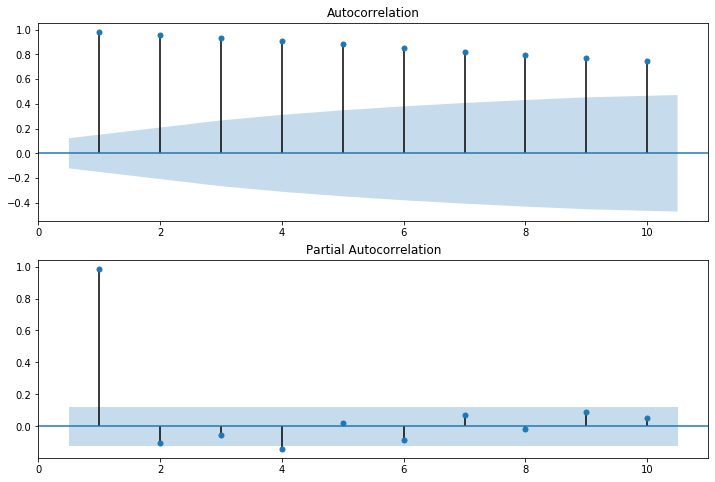

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 # Plot the ACF of df on ax1
plot_acf(df_jsw_comp['close'], lags=10,zero=False,ax=ax1)

# Plot the PACF of df on ax2
plot_pacf(df_jsw_comp['close'], lags=10,zero=False,ax=ax2)
plt.show()
#From the below graphs we can easily say that the data is non stationary
#Indicating auto correlation is all the lags.

# ACF PACF plot for 1 day difference of closing price ( stationary data)

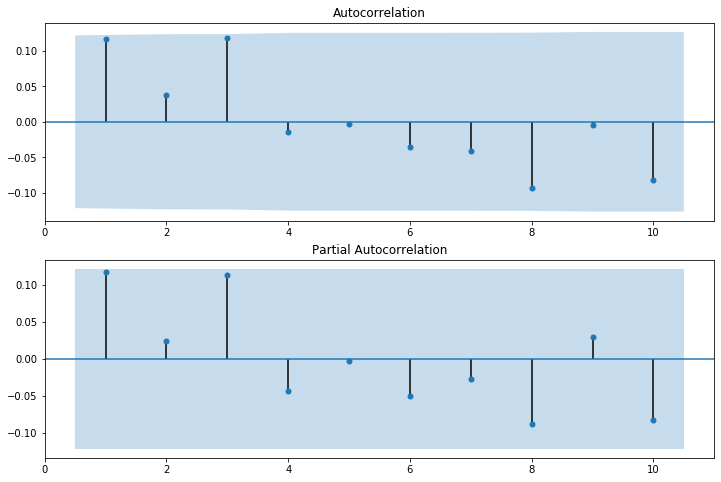

In [22]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 # Plot the ACF of df on ax1
plot_acf(df_jsw_comp['1d_diff'], lags=10,zero=False,ax=ax1)

# Plot the PACF of df on ax2
plot_pacf(df_jsw_comp['1d_diff'], lags=10,zero=False,ax=ax2)
plt.show()
#From the below graphs we can easily say that the data is non stationary
#Indicating auto correlation is all the lags.

From the above plot we can see that the lags are at 1 and 3 are close to be significant 

In [23]:
#Before we fit the data to the model we need to split the dataset to train and test
df_jsw_train,df_jsw_test = getTrainTestSplit(df_jsw_comp,.8)


In [24]:
df_jsw_train.head()

,date,close,1d_diff
date,,,
2018-01-02,2018-01-02,1797.35,18.15
2018-01-03,2018-01-03,1781.65,-15.70
2018-01-04,2018-01-04,1778.70,-2.95
2018-01-05,2018-01-05,1784.35,5.65
2018-01-08,2018-01-08,1786.10,1.75


In [25]:
df_jsw_test.head()

,date,close,1d_diff
date,,,
2018-10-18,2018-10-17,2049.6,0.0
2018-10-19,2018-10-19,2019.3,-30.3
2018-10-22,2018-10-22,2092.0,72.7
2018-10-23,2018-10-23,2122.6,30.6
2018-10-24,2018-10-24,2139.7,17.1


In [26]:
# We Would be take the closing price aand since we know that the data becomes 
#Stationary at 1 order of difference therefore d=1 
# From the ACF and PACF we observe that the lags at 2 and 4 are significant
# Therefore initially we fit the simpler model and proceed with the complex models (Higher lags)
#To find the best model

ar_2_ma_2 = ARIMA(df_jsw_train['close'],order=(2,1,2))
result_ar_2_ma_2 = ar_2_ma_2.fit()
res_ar_2_ma_2 = result_ar_2_ma_2.resid

In [27]:
result_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                  206
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1048.252
Method:                       css-mle   S.D. of innovations             39.129
Date:                Sat, 06 Jun 2020   AIC                           2108.505
Time:                        20:47:10   BIC                           2128.472
Sample:                    01-03-2018   HQIC                          2116.580
                         - 10-17-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0428      2.752      0.379      0.705      -4.351       6.437
ar.L1.D.close     1.8690      0.014    136.410      0.000       1.842       1.896
ar.L2.D.close    -0.9922      0.015    -64.103      0.000      -1.023      -0.962
ma.L1.D.close    -1.8393      0.037    -49.881      0.000      -1.912      -1.767
ma.L2.D.close     0.9633      0.042     22.704      0.000       0.880       1.046
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9418           -0.3476j            1.0039           -0.0563
AR.2            0.9418           +0.3476j            1.0039            0.0563
MA.1            0.9546           -0.3560j            1.0189           -0.0568
MA.2            0.9546           +0.3560j            1.0189            0.0568
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'JSW Holding :ACF of Residuals for res_ar_2_ma_2')

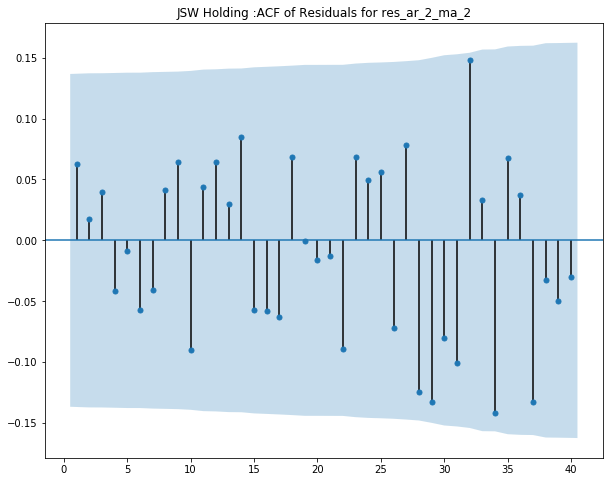

In [28]:
plot_acf(res_ar_2_ma_2, lags=40,zero=False)
plt.title("JSW Holding :ACF of Residuals for res_ar_2_ma_2")
# The residuals are uncorrelated

# ARIMA 4,1 4

In [29]:
#Lets try to fit the model at higher order 4,4
# ar_4_ma_4 = ARIMA(df_jsw_train['close'],order=(4,1,4))
# result_ar_4_ma_4 = ar_4_ma_4.fit()
# res_ar_4_ma_4 = result_ar_4_ma_4.resid


In [30]:
for p in range (1,5):
    for q in range (1,5):
        try:
            mod = ARIMA(df_jsw_train['close'],order=(p,1,q))
            res = mod.fit()
            print(f"AIC:{res.aic} \t BIC:{res.bic} \t LLR:{res.llf} \t for ARIMA model p:{p}, d:1,  q:{q} ")
        except:
            print(p,q,None,None)

AIC:2109.021246289519 	 BIC:2122.332750964677 	 LLR:-1050.5106231447594 	 for ARIMA model p:1, d:1,  q:1
AIC:2110.876699853289 	 BIC:2127.516080697237 	 LLR:-1050.4383499266446 	 for ARIMA model p:1, d:1,  q:2
AIC:2111.90315093079 	 BIC:2131.8704079435274 	 LLR:-1049.951575465395 	 for ARIMA model p:1, d:1,  q:3
AIC:2109.1953171232726 	 BIC:2132.4904503047997 	 LLR:-1047.5976585616363 	 for ARIMA model p:1, d:1,  q:4
AIC:2110.9179766945635 	 BIC:2127.5573575385115 	 LLR:-1050.4589883472818 	 for ARIMA model p:2, d:1,  q:1
AIC:2108.50475061442 	 BIC:2128.4720076271574 	 LLR:-1048.25237530721 	 for ARIMA model p:2, d:1,  q:2
AIC:2113.766845765524 	 BIC:2137.061978947051 	 LLR:-1049.883422882762 	 for ARIMA model p:2, d:1,  q:3
C:\Users\Nagar_gphnzrt\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
AIC:2115.5590617671965 	 BIC:2142.182071117

The ARIMA model at p = 4, d=1  and q =4 gave us error 'SVF converge' which means that the higher lags are not suitable for the data set.
Also we tried the below combinations and found the error of HElissan converge
- 3,1,4
- 4,1,3
- 4,1,4
- 3,1,2

All the above p and q combinations failed restricting us to try out with the below combinations

- 2,1,3
- 3,1,3
- 1,1,3


BUt all the above model combinations gave us insignificant coeeficents and higher AIC


In [31]:
#Lets try to fit the model at higher order 4,4
ar_3_ma_3 = ARIMA(df_jsw_train['close'],order=(3,1,3))
result_ar_3_ma_3 = ar_3_ma_3.fit()
res_ar_3_ma_3 = result_ar_3_ma_3.resid

result_ar_3_ma_3.summary()

C:\Users\Nagar_gphnzrt\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                  206
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1047.783
Method:                       css-mle   S.D. of innovations             38.830
Date:                Sat, 06 Jun 2020   AIC                           2111.567
Time:                        20:47:15   BIC                           2138.190
Sample:                    01-03-2018   HQIC                          2122.334
                         - 10-17-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1969      3.409      0.351      0.726      -5.485       7.879
ar.L1.D.close     1.4250      0.425      3.351      0.001       0.592       2.258
ar.L2.D.close    -1.4014      0.401     -3.499      0.000      -2.186      -0.616
ar.L3.D.close     0.4649      0.392      1.186      0.236      -0.304       1.233
ma.L1.D.close    -1.3251      0.436     -3.042      0.002      -2.179      -0.471
ma.L2.D.close     1.3694      0.364      3.763      0.000       0.656       2.083
ma.L3.D.close    -0.3987      0.432     -0.923      0.356      -1.245       0.448
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4945           -0.9042j            1.0306           -0.1703
AR.2            0.4945           +0.9042j            1.0306            0.1703
AR.3            2.0253           -0.0000j            2.0253           -0.0000
MA.1            0.4632           -0.8863j            1.0000           -0.1734
MA.2            0.4632           +0.8863j            1.0000            0.1734
MA.3            2.5080           -0.0000j            2.5080           -0.0000
-----------------------------------------------------------------------------
"""

``` 
From the above we that the AIC value is high as compared to the 2,1,2 ARIMA model 
and also we notice that one of the MA coeffiencet becomes insignificant
Where-as in ARIMA 2,1,2 All the coeeffecients are significant.
 ```


# The Best model identified for the Stock JSW  holding is ARIMA 2,1,2

As we can see above that the best model of p and q which gives the lowest aic is p = 2 d=1 and q=2

In [32]:
model_jsw = ARIMA(df_jsw_train.close,order=(2,1,2))
results_jsw = model_jsw.fit()
residual_jsw = results_jsw.resid

In [33]:
# We Already know that the residuals are uncorrelated

#We now Predict the test set
df_jsw_test.head()

,date,close,1d_diff
date,,,
2018-10-18,2018-10-17,2049.6,0.0
2018-10-19,2018-10-19,2019.3,-30.3
2018-10-22,2018-10-22,2092.0,72.7
2018-10-23,2018-10-23,2122.6,30.6
2018-10-24,2018-10-24,2139.7,17.1


In [34]:
start_date = '2018-10-18'
end_date = '2018-12-28'

In [35]:
#When calling a predict method we get the difference of the order defined while building the model
# In out scenario the order was 

df_jsw_predict = pd.DataFrame(results_jsw.predict(start=start_date,end=end_date),columns=['predict_diff'],index = df_jsw_test.index)

In [36]:
df_jsw_predict.head()
df_jsw_predict['date']=df_jsw_predict.index

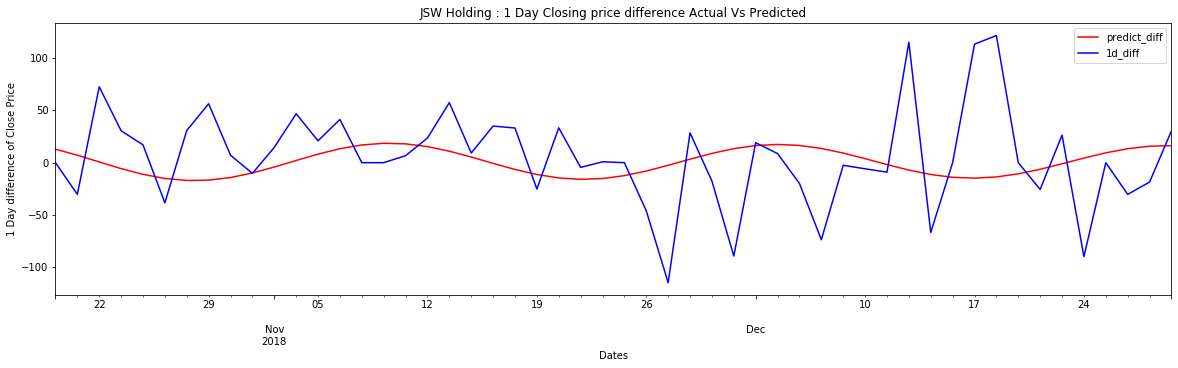

In [37]:
df_jsw_predict.predict_diff.plot(figsize=(20,5),color='red')
df_jsw_test['1d_diff'][start_date:end_date].plot(figsize=(20,5),color='blue')
plt.ylabel('1 Day difference of Close Price')
plt.xlabel('Dates')
plt.title('JSW Holding : 1 Day Closing price difference Actual Vs Predicted')
plt.legend()
plt.show()

In [38]:
#Convert the prediction difference to predicted close
# currentDayDifference = current day close - Previous day close
#CurrentdayClose = previousDayclose+currentDayDifference
df_jsw_predict['close'] = df_jsw_test['close']
df_jsw_predict['predicted_close'] = df_jsw_predict.close.shift(1)+df_jsw_predict['predict_diff']

In [39]:
df_jsw_predict.head()

,predict_diff,date,close,predicted_close
date,,,,
2018-10-18,12.922701,2018-10-18,2049.6,NaN
2018-10-19,7.166626,2018-10-19,2019.3,2056.766626
2018-10-22,0.701023,2018-10-22,2092.0,2020.001023
2018-10-23,-5.671977,2018-10-23,2122.6,2086.328023
2018-10-24,-11.167917,2018-10-24,2139.7,2111.432083


In [40]:
df_jsw_predict.dropna(inplace=True)

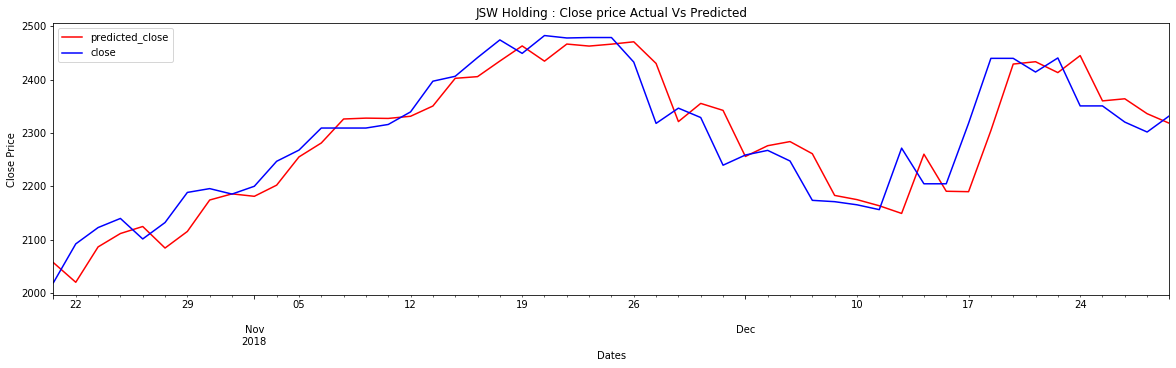

In [41]:
df_jsw_predict.predicted_close.plot(figsize=(20,5),color='red')
df_jsw_predict['close'][start_date:end_date].plot(figsize=(20,5),color='blue')
plt.ylabel('Close Price')
plt.xlabel('Dates')
plt.title('JSW Holding : Close price Actual Vs Predicted')
plt.legend()
plt.show()

# Calculating the Accuracy of predicted values

In [42]:
# Accuracy metrics
def prediction_accuracy(prediction, actual):
    mape = np.mean(np.abs(prediction - actual)/np.abs(actual)) * 100  # MAPE
    me = np.mean(prediction - actual)            # ME
    mae = np.mean(np.abs(prediction - actual))    # MAE
    mpe = np.mean((prediction - actual)/actual)   # MPE
    rmse = np.mean((prediction - actual)**2)**.5  # RMSE
    return({'mape':f'{mape.round(2)}%', 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse 
            })

In [43]:
jsw_actual=df_jsw_predict[1:].close.values
jsw_predict=df_jsw_predict[1:].predicted_close.values
prediction_accuracy(jsw_predict,jsw_actual)

{'mape': '1.63%',
 'me': -6.062124582124762,
 'mae': 37.35591972167849,
 'mpe': -0.002570780753088992,
 'rmse': 51.004325177508704}

# From above we interpret the following
MAPE: The mean absolute percent error (MAPE) expresses accuracy as a percentage of the error.
mape < 5% which means that our model performed well in predicting the close price.

MAE and RMSE: Both MAE and RMSE express average model prediction error in units of the variable of interest, Lower is the better.

We can see that we have an MAE of 37.35 which means that our model predicted values have an error of 37.33 Rupees with unknown direction


# Let's Forecast JSW Holding closing price for the date 2-Jan to 5 or days

In [44]:
#For forecasting we need to again build the model using the complete data.
jsw_model_forecast = ARIMA(df_jsw_comp.close,order=(2,1,2))
jsw_result_forecast = jsw_model_forecast.fit()
jsw_residual_forecast = jsw_result_forecast.resid

In [45]:
# Forecasting for n_periods

In [53]:
n_periods = 10

In [54]:
jsw_forecast,std,conf = jsw_result_forecast.forecast(steps = n_periods,alpha=.05)

In [55]:
df_forecast = pd.DataFrame()
df_forecast['forecasted_close'] = pd.Series(jsw_forecast)
df_forecast['lower_conf'] = pd.Series(conf[:,0])
df_forecast ['higher_conf']= pd.Series(conf[:,1])
#Adding date range for the forecasted close price
datelist = pd.date_range('2019-01-02', periods=n_periods,freq='b')
df_forecast['date'] = pd.Series(datelist)
df_forecast.index = df_forecast['date']


In [56]:
df_forecast.head()

,forecasted_close,lower_conf,higher_conf,date
date,,,,
2019-01-02,2333.607751,2253.340351,2413.875152,2019-01-02
2019-01-03,2336.448728,2214.744178,2458.153277,2019-01-03
2019-01-04,2337.996171,2185.490433,2490.501909,2019-01-04
2019-01-07,2340.548972,2159.604952,2521.492991,2019-01-07
2019-01-08,2342.250562,2137.207582,2547.293542,2019-01-08


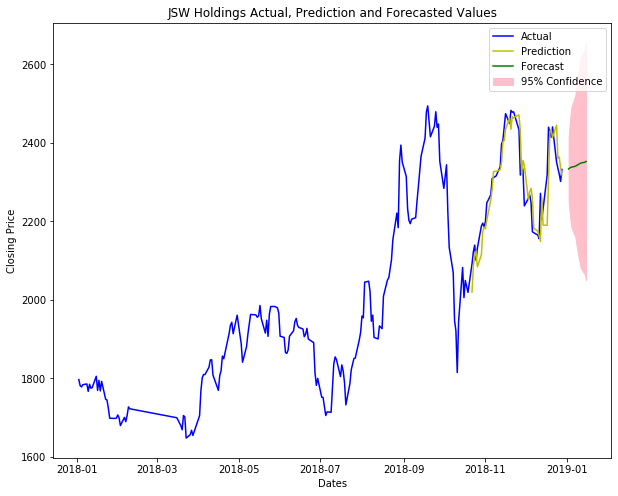

In [57]:
plt.figure()
plt.plot(df_jsw_comp.date,df_jsw_comp.close,color = 'blue',label='Actual')
plt.plot(df_jsw_predict.date[1:],df_jsw_predict.predicted_close[1:],color='y',label='Prediction')
plt.plot(df_forecast.date,df_forecast.forecasted_close,color='g',label='Forecast')
plt.fill_between(df_forecast.date,df_forecast.lower_conf,df_forecast.higher_conf	,color='pink',label='95% Confidence')
plt.legend()
plt.ylabel('Closing Price')
plt.xlabel('Dates')
plt.title("JSW Holdings Actual, Prediction and Forecasted Values")
plt.show()


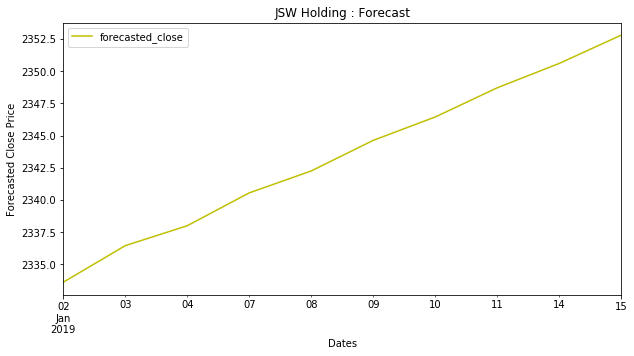

In [60]:
df_forecast.forecasted_close.plot(figsize=(10,5),color='y')
plt.ylabel('Forecasted Close Price')
plt.xlabel('Dates')
plt.title('JSW Holding : Forecast')
plt.legend()
plt.show()

In [59]:
df_forecast

,forecasted_close,lower_conf,higher_conf,date
date,,,,
2019-01-02,2333.607751,2253.340351,2413.875152,2019-01-02
2019-01-03,2336.448728,2214.744178,2458.153277,2019-01-03
2019-01-04,2337.996171,2185.490433,2490.501909,2019-01-04
2019-01-07,2340.548972,2159.604952,2521.492991,2019-01-07
2019-01-08,2342.250562,2137.207582,2547.293542,2019-01-08
2019-01-09,2344.628275,2116.780383,2572.476166,2019-01-09
2019-01-10,2346.442818,2098.299088,2594.586548,2019-01-10
2019-01-11,2348.710132,2081.190916,2616.229349,2019-01-11
2019-01-14,2350.603714,2065.326659,2635.880769,2019-01-14
